In [1]:
import time
import sys
import pathlib
import os
import numpy as np
import cv2 as cv
from spatialmath import SE3
from scipy.spatial.transform import Rotation as R, Slerp
import matplotlib.pyplot as plt
from roboticstoolbox import DHRobot, RevoluteDH
from spatialmath.base import trotx, troty, trotz
import csv
import pathlib
import roboticstoolbox as rtb

notebook_path = os.getcwd()
sys.path.append(str(pathlib.Path(notebook_path).parent))
from classrobot.robot_movement import RobotControl
from classrobot.UR5e_DH import UR5eDH
from classrobot.planning import Planning



In [2]:
RPY = [-1.7318443587261685, 0.686842056802218, -1.7312759524010408]


HOME_POS = [0.701172053107018, 0.184272460738082, 0.1721568294843568] + RPY

# HOME_POS_JOINTS = [0.7144814729690552, -1.9380423031248988, -2.0520365238189697,
#                    -2.2719952068724574, -0.9003556410418909, 2.3653483390808105]
GOAL = [0.9034970156209872, 0.18427154391614353, -0.43708867396716417, -1.7319726840891074, 0.6868197088217621, -1.7312654748314675]

print(GOAL)

[0.9034970156209872, 0.18427154391614353, -0.43708867396716417, -1.7319726840891074, 0.6868197088217621, -1.7312654748314675]


In [3]:
# Robot UR5e DH parameters
# init DH TABLE
robotDH = UR5eDH()
tool_offset = SE3(0, 0, 0.200)
robotDH.tool = tool_offset
print(robotDH)

# init real robot ur5e
robot_ip = "192.168.200.10"
real_robot = RobotControl()
real_robot.robot_release()
real_robot.robot_init(robot_ip)
# make sure the robot is in home position
real_robot.robot_move_home()



DHRobot: UR5e (by Universal Robotics), 6 joints (RRRRRR), dynamics, standard DH parameters
┌─────┬────────┬─────────┬────────┐
│ θⱼ  │   dⱼ   │   aⱼ    │   ⍺ⱼ   │
├─────┼────────┼─────────┼────────┤
│  q1 │ 0.1625 │       0 │  90.0° │
│  q2 │      0 │  -0.425 │   0.0° │
│  q3 │      0 │ -0.3922 │   0.0° │
│  q4 │ 0.1333 │       0 │  90.0° │
│  q5 │ 0.0997 │       0 │ -90.0° │
│  q6 │ 0.0996 │       0 │   0.0° │
└─────┴────────┴─────────┴────────┘

┌──────┬─────────────────────────────────────┐
│ tool │ t = 0, 0, 0.2; rpy/xyz = 0°, 0°, 0° │
└──────┴─────────────────────────────────────┘

┌────────┬────────┬────────┬────────┬────────┬────────┬────────┐
│   name │ q0     │ q1     │ q2     │ q3     │ q4     │ q5     │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ q_HOME │  40.2° │  10.6° │  9.86° │ -99.2° │  39.4° │ -99.2° │
└────────┴────────┴────────┴────────┴────────┴────────┴────────┘

Moving to home position...
Arrived at home position.


In [4]:
# init current position
pos_current = real_robot.robot_get_position()
T_current = SE3(pos_current[0], pos_current[1], pos_current[2]) @ SE3.RPY(pos_current[3], pos_current[4], pos_current[5], unit='rad')
# Doing forward kinematics to get the current pose
joint_position  = real_robot.robot_get_joint_rad()
print("Current joint position:\n", joint_position)
robotDH.q = joint_position
T_fk = robotDH.fkine(robotDH.q)
print("FK position:\n", T_fk)

# init goal position
pos_end = GOAL
T_end   = SE3(pos_end[0], pos_end[1], pos_end[2]) @ SE3.RPY(pos_end[3], pos_end[4], pos_end[5], unit='rad')

print("Start TCP Pose:\n", T_current)

# compare error between T_fk and T_current
# Calculate RMSE for translation and rotation errors
translation_error = T_fk.t - T_current.t
rotation_error = T_fk.rpy() - T_current.rpy()

rmse_translation = np.sqrt(np.mean(translation_error**2))
rmse_rotation = np.sqrt(np.mean(rotation_error**2))

print("RMSE Translation error between FK and current pose:", rmse_translation)
print("RMSE Rotation error (RPY) between FK and current pose:", rmse_rotation)

Current joint position:
 [0.7144397497177124, -1.9380585155882777, -2.0520169734954834, -2.2720471821227015, -0.9003098646747034, 2.3653817176818848]
FK position:
    0.02028   0.04221   0.9989    0.6994    
  -0.7225   -0.69      0.04383   0.1837    
   0.6911   -0.7226    0.0165    0.1702    
   0         0         0         1         

Start TCP Pose:
   -0.1235   -0.0583    0.9906    0.7012    
  -0.7634    0.6434   -0.05733   0.1843    
  -0.6341   -0.7633   -0.124     0.1722    
   0         0         0         1         

RMSE Translation error between FK and current pose: 0.0016027475475410486
RMSE Rotation error (RPY) between FK and current pose: 0.8507297497433252


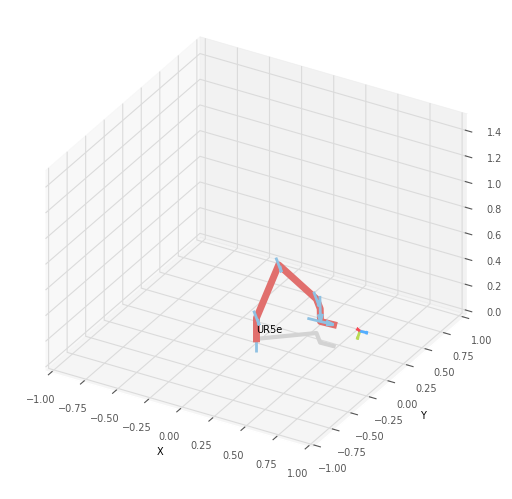

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'UR5e')

<Figure size 640x480 with 0 Axes>

In [5]:
# visualize the robot at Home position
robotDH.plot(joint_position, block=False, limits=[-1, 1, -1, 1, 0, 1.5],vellipse=False)

## Cubic polynomial trajectory planning

In [6]:
# init planning class
# init dt that use in planning
dt = 1/100
planning = Planning(dt)

# Zero initial and final Cartesian velocities (for a smooth start/stop)
v0_cart = 0.0
v1_cart = 0.0

# Extract the translation from T_start and T_end
pos_start = T_current.t  # This is a (3,) numpy array [x, y, z]
pos_end   = T_end.t
# Extract the roll, pitch, yaw angles from T_start and T_end
rpy_start = T_current.rpy()
rpy_end   = T_end.rpy()
print("Start position:", pos_start)
print("End position:", pos_end)
# cal distance between start and end position
dist = np.linalg.norm(pos_end - pos_start)
print("Distance between start and end position:", dist)
# Define the total trajectory duration (seconds)
v_tool = 0.05     # Desired tool speed in m/s
a_max = 0.25     # Maximum acceleration in m/s^2
T_total, profile = planning.compute_traj_time(dist, v_tool, a_max)
print("Selected Profile:", profile)
print("Total Trajectory Time: {:.3f} seconds".format(T_total))
num_steps = int(np.ceil(T_total / dt)) + 1  # Use np.ceil for consistency
t_vec = np.linspace(0, T_total, num_steps)


# Generate the translational (x, y, z) trajectory using cubic interpolation.
pos_traj = np.zeros((len(t_vec), 3))
speed_traj = np.zeros((len(t_vec), 3))  # Initialize speed trajectory array
acc_traj = np.zeros((len(t_vec), 3))  # Initialize acceleration trajectory array
# rpy_traj = np.zeros((len(t_vec), 3))  # Initialize RPY trajectory array



for axis in range(3):
    t_arr, p_arr, v_arr, a_arr = planning.cubic_trajectory(
        pos_start[axis], pos_end[axis], v0_cart, v1_cart, T_total
    )
    pos_traj[:, axis] = p_arr.flatten()
    speed_traj[:, axis] = v_arr.flatten()
    acc_traj[:, axis] = a_arr.flatten()

# how many points in the trajectory?
print("Number of points in the trajectory:", len(pos_traj))
# print("Number of points in the trajectory:", len(rpy_traj))
print("Number of points in the trajectory:", len(speed_traj))
print("Number of points in the trajectory:", len(acc_traj))

# print("rpy at start (x-axis):", rpy_traj[-1])

# Check the endpoints for speed (should be 0)
print("Speed at start (x-axis):", speed_traj[0, 0])
print("Speed at end (x-axis):", speed_traj[-1, 0])
print("Number of trajectory points:", len(pos_traj))

# # For the orientation, interpolate using the SE3.interp method.
traj_T = []
for j, t in enumerate(t_vec):
    s = t / T_total  # normalized time [0, 1]
    T_interp = T_current.interp(T_end, s)  # Interpolate orientation
    # Replace the translation with the cubic trajectory value for consistency:
    T_interp = SE3.Rt(T_interp.R[:3, :3], pos_traj[j, :])
    traj_T.append(T_interp)

print("Interpolated TCP poses:")
waypoints = []
for T in traj_T:
    waypoints.append(T)

print("Total Waypoint:", len(waypoints))
print("Waypoints start:")
print(waypoints[0])
print("Waypoints goal:")
print(waypoints[-1])
# convert waypoint to tcp pose
waypoint_goal_tcp = waypoints[-1].t.tolist() + list(waypoints[-1].rpy())
print("Waypoints goal TCP:", waypoint_goal_tcp)


Start position: [0.70118935 0.18429503 0.17216232]
End position: [ 0.90349702  0.18427154 -0.43708867]
Distance between start and end position: 0.6419619628694858
Selected Profile: Trapezoidal
Total Trajectory Time: 13.039 seconds
Number of points in the trajectory: 1305
Number of points in the trajectory: 1305
Number of points in the trajectory: 1305
Speed at start (x-axis): 0.0
Speed at end (x-axis): 0.0
Number of trajectory points: 1305
Interpolated TCP poses:
Total Waypoint: 1305
Waypoints start:
  -0.1235   -0.0583    0.9906    0.7012    
  -0.7634    0.6434   -0.05733   0.1843    
  -0.6341   -0.7633   -0.124     0.1722    
   0         0         0         1         

Waypoints goal:
  -0.1236   -0.05842   0.9906    0.9035    
  -0.7633    0.6435   -0.05726   0.1843    
  -0.6341   -0.7632   -0.1241   -0.4371    
   0         0         0         1         

Waypoints goal TCP: [0.9034970156209872, 0.18427154391614353, -0.4370886739671643, -1.7319726840891077, 0.686819708821762, -

## plotting trajectory

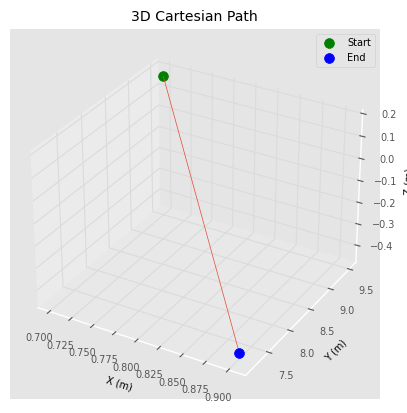

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1) 3D path of the end‑effector
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_start[0], pos_start[1], pos_start[2], color='green', s=50, label="Start")
ax.scatter(pos_end[0], pos_end[1], pos_end[2], color='blue', s=50, label="End")
ax.plot(
    pos_traj[:,0],  # x
    pos_traj[:,1],  # y
    pos_traj[:,2],  # z
)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Cartesian Path')
ax.legend()
plt.show()



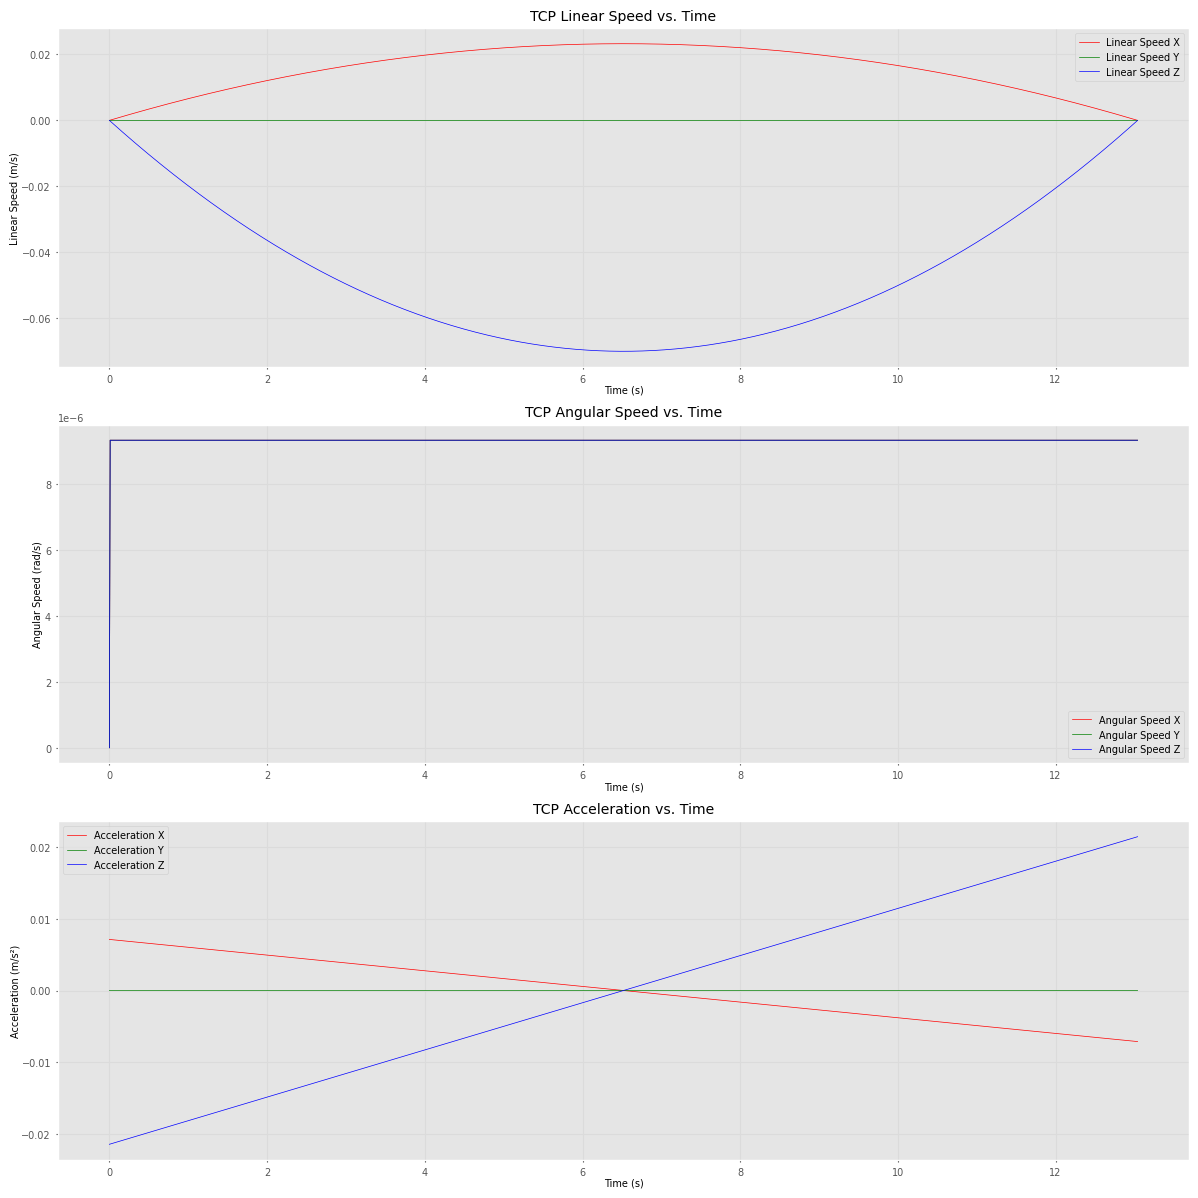

In [8]:
import numpy as np

import matplotlib.pyplot as plt

# Calculate angular speeds from SE3 poses
angular_speeds = np.zeros((len(traj_T), 3))  # Initialize array for angular speeds
for i in range(1, len(traj_T)):
    # Compute the relative transformation between consecutive poses
    delta_T = traj_T[i - 1].inv() * traj_T[i]
    # Extract the angular velocity (rotation vector) from the relative transformation
    angular_speeds[i, :] = delta_T.angvec()[0] / dt  # Divide by dt to get angular speed

# Create a figure with a specified size
plt.figure(figsize=(12, 12))

# Plot linear speeds
plt.subplot(3, 1, 1)
plt.plot(t_arr, speed_traj[:, 0], 'r-', label='Linear Speed X')  # Red dots for X axis speed
plt.plot(t_arr, speed_traj[:, 1], 'g-', label='Linear Speed Y')  # Green dots for Y axis speed
plt.plot(t_arr, speed_traj[:, 2], 'b-', label='Linear Speed Z')  # Blue dots for Z axis speed
plt.xlabel("Time (s)")
plt.ylabel("Linear Speed (m/s)")
plt.title("TCP Linear Speed vs. Time")
plt.legend()
plt.grid(True)

# Plot angular speeds
plt.subplot(3, 1, 2)
plt.plot(t_arr, angular_speeds[:, 0], 'r-', label='Angular Speed X')  # Red line for X axis angular speed
plt.plot(t_arr, angular_speeds[:, 1], 'g-', label='Angular Speed Y')  # Green line for Y axis angular speed
plt.plot(t_arr, angular_speeds[:, 2], 'b-', label='Angular Speed Z')  # Blue line for Z axis angular speed
plt.xlabel("Time (s)")
plt.ylabel("Angular Speed (rad/s)")
plt.title("TCP Angular Speed vs. Time")
plt.legend()
plt.grid(True)

# Plot acceleration
plt.subplot(3, 1, 3)
plt.plot(t_arr, acc_traj[:, 0], 'r-', label='Acceleration X')  # Red line for X axis acceleration
plt.plot(t_arr, acc_traj[:, 1], 'g-', label='Acceleration Y')  # Green line for Y axis acceleration
plt.plot(t_arr, acc_traj[:, 2], 'b-', label='Acceleration Z')  # Blue line for Z axis acceleration
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("TCP Acceleration vs. Time")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


## REAL robot trajectory planning

In [9]:
joint_trajectory = []  # To store the computed joint configurations for each waypoint

# Iterate over every Cartesian waypoint in traj_T.
for idx, T_pose in enumerate(traj_T):
    # Extract the translation (x, y, z)
    pos = T_pose.t.tolist()  # Assuming T_pose.t returns a 3-element numpy array
    # Extract the orientation in roll, pitch, yaw. This depends on your SE3 class.
    # For example, if T_pose has an rpy() method, you might do:
    orientation = T_pose.rpy()  # This should return a list or array of 3 elements [roll, pitch, yaw]
    # Combine position and orientation into one 6-element list.
    tcp_pose_list = pos + list(orientation)
    
    # Call your IK function (make sure to include the parentheses and pass the target pose).
    q_joint = real_robot.robot_get_ik(tcp_pose_list)
    
    # Optionally, you can check if the solution is valid here.
    if q_joint is None:
        print(f"IK failed for waypoint {idx}.")
        break  # or handle the error as needed
    
    # Otherwise, append the computed joint angles.
    joint_trajectory.append(q_joint)

# Make sure that you have obtained a joint configuration for each waypoint.
if len(joint_trajectory) != len(traj_T):
    raise RuntimeError("Incomplete joint trajectory. Please check IK solutions for all waypoints.")

print("Successfully computed joint trajectory for all waypoints.")




Successfully computed joint trajectory for all waypoints.


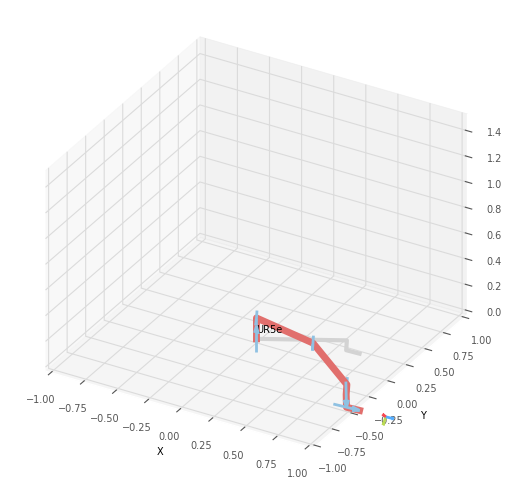

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'UR5e')

<Figure size 640x480 with 0 Axes>

In [10]:
robotDH.plot(joint_trajectory[-1], block=False, limits=[-1, 1, -1, 1, 0, 1.5],vellipse=False)

In [11]:
print("Joint trajectory length:", waypoints[-1].t.tolist()+list(waypoints[-1].rpy()))

Joint trajectory length: [0.9034970156209872, 0.18427154391614353, -0.4370886739671643, -1.7319726840891077, 0.686819708821762, -1.7312654748314678]


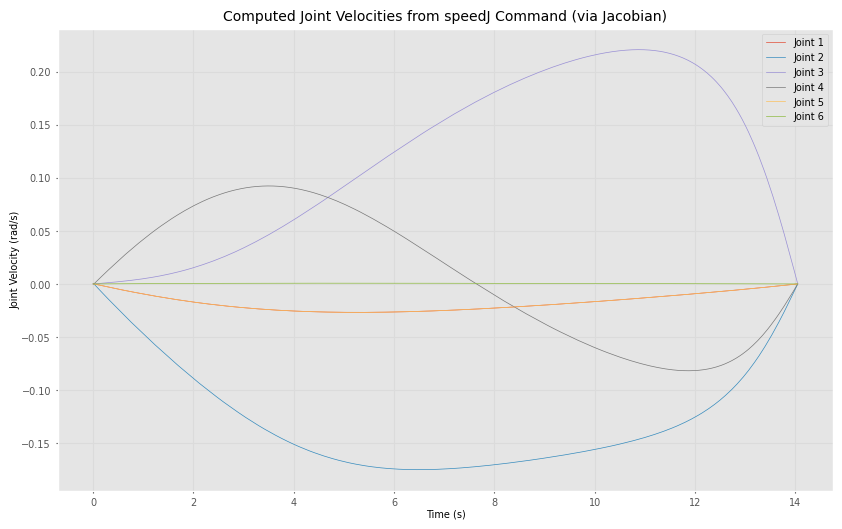

In [12]:
# test speedJ with joint trajectory which not work! try change to speedL is better!
import numpy as np
import time
import matplotlib.pyplot as plt

# Control loop time step and joint acceleration.
joint_acceleration = 0.25  # rad/s^2
# Lists to store computed joint velocity commands and time stamps for plotting.
computed_joint_velocities = []  # Each element will be an array of joint velocities (rad/s)
time_stamps = []                 # Record the simulation time for each iteration
start_time = time.time()


for i in range(len(traj_T)):
    current_time = time.time() - start_time
    time_stamps.append(current_time)
    
    x_dot_des = speed_traj[i, :]  # Desired linear speed
    ang_vel = np.zeros(3)  # Initialize angular velocity
    x_dot_des = np.concatenate((x_dot_des, ang_vel))  # Shape: (6,)
    x_dot_des = np.array(x_dot_des, dtype=float)  # Ensure it's a numpy array
    q_current  = joint_trajectory[i]  # Current joint configuration
    # q_current = real_robot.robot_get_joint_rad()
    J = robotDH.jacob0(q_current)  # J should be a 6x6 matrix.
    dq = np.linalg.inv(J) @ x_dot_des
    # check sigularity of Jacobian matrix
    if np.linalg.cond(J) < 1e-09:
        print("Jacobian is singular, cannot compute joint velocities.")
        break
    
    # Store the computed joint velocities for plotting later.
    computed_joint_velocities.append(dq)
    # Send the joint velocity command to the robot using the speedJ command.
    real_robot.robot_speed_J(dq.tolist(), acceleration=joint_acceleration, time=dt)
    # Delay to simulate control-loop timing.
    time.sleep(dt)
# Convert the list of computed joint velocities to a numpy array.
computed_joint_velocities = np.array(computed_joint_velocities)  # Shape: (num_steps, num_joints)


# --- Plotting the Computed Joint Velocities ---
plt.figure(figsize=(10, 6))
num_joints = computed_joint_velocities.shape[1]
for j in range(num_joints):
    plt.plot(time_stamps, computed_joint_velocities[:, j], label=f'Joint {j+1}')
plt.xlabel("Time (s)")
plt.ylabel("Joint Velocity (rad/s)")
plt.title("Computed Joint Velocities from speedJ Command (via Jacobian)")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
real_robot.robot_move_speed_stop()
real_robot.robot_move_home()
real_robot.robot_release()



Moving to home position...
Arrived at home position.
